# Milestone 3

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import ast 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

## 1. Exploration of the dataset

### Movies metadata

In [2]:
movies = pd.read_table('~/ADA2023/Project/Data/MovieSummaries/movie.metadata.tsv', header=None)
movies.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']

In [3]:
# Remove leading and trailing spaces, then parse the dictionaries
movies['Movie languages'] = movies['Movie languages'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie countries'] = movies['Movie countries'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie genres'] = movies['Movie genres'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})

### Characters metadata

In [4]:
characters = pd.read_table('~/ADA2023/Project/Data/MovieSummaries/character.metadata.tsv', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character name','Actor date of birth','Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']

## 2. Complementary datasets

The success can be characterized based on several factors, 
- Longevity: for how long has the actor been in the film industry? 
- In how many films the actor has participated?
- IMDB ratings:
- The Oscars
- Google search results
- Film revenue
- Number of film spectators

Some of these indicators require additional datasets. We thus complement our analysis with data on awards, on ratings, and on popularity.

## 2.1 [Oscars' winners and nominees](https://datahub.io/rufuspollock/oscars-nominees-and-winners)

### The dataset

In [5]:
oscars = pd.read_csv('~/ADA2023/Project/Data/oscar_awards.csv')

In [6]:
oscars.columns

Index(['year', 'category', 'winner', 'entity'], dtype='object')

**Oscar nominations and awards by gender**

In [7]:
oscars_actors = oscars[(oscars['category'].str.contains("ACTOR")) | (oscars['category'].str.contains("ACTRESS"))]

In [8]:
# Group by gender and year and calculate the number of total observations and winners
mask = oscars_actors['category'].str.contains("ACTOR")

oscars_actors.loc[:, 'gender'] = 'Female'
oscars_actors.loc[mask, 'gender'] = 'Male'

oscars_per_year_gender = oscars_actors.groupby(['year', 'gender'])['winner'].agg(['count', 'sum']).reset_index()
oscars_per_year_gender = oscars_per_year_gender.rename(columns={'count': 'Nominees', 'sum': 'Winners'})

/var/folders/2d/tjq3n5693zgf146ztjtxnzr80000gp/T/ipykernel_77876/2439912357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oscars_actors.loc[:, 'gender'] = 'Female'


In [9]:
oscars_per_year_gender

,year,gender,Nominees,Winners
0,1927,Female,3,1
1,1927,Male,2,1
2,1928,Female,6,1
3,1928,Male,5,1
4,1929,Female,6,1
...,...,...,...,...
175,2015,Male,10,2
176,2016,Female,10,2
177,2016,Male,10,2
178,2017,Female,10,2


Until 1975, there was only one category for actors and one for actresses. Nowadays, there are leading and supporting categories for each gender. We choose to consider both categories as Oscar winner indistinctively.

**Merge with CMU Movie Corpus**

In [10]:
characters_oscars = characters.merge(oscars_actors, left_on='Actor name', right_on='entity', how='left')

print('There are {}% of Oscar nominees or winners in the movies dataset.'.format(round(100 - characters_oscars['entity'].isna().sum()/characters_oscars.shape[0] * 100,2)))

There are 14.31% of Oscar nominees or winners in the movies dataset.


In [11]:
characters_oscars_test = characters.merge(oscars_actors, left_on='Actor name', right_on='entity', how='right')

print('Only {}% of Oscar nominees or winners ({}) do not appear in our movies dataset.'.format(round(characters_oscars_test['Actor name'].isna().sum()/characters_oscars_test.shape[0] * 100,2), characters_oscars_test['Actor name'].isna().sum()))

Only 0.04% of Oscar nominees or winners (28) do not appear in our movies dataset.


In [12]:
characters_oscars_test[characters_oscars_test['Actor name'].isna()][['entity', 'year', 'winner']]

,entity,year,winner
3940,Anne Shirley,1937,False
3976,Dame May Whitty,1937,False
5774,Charles Chaplin,1940,False
6037,Albert Basserman,1940,False
8259,Dame May Whitty,1942,False
18920,Sir Laurence Olivier,1956,False
19830,Vittorio De Sica,1957,False
24975,Dame Edith Evans,1963,False
25816,Dame Edith Evans,1964,False
27123,Anouk Aimee,1966,False


A few Oscar winners and nominees don't appear in our dataset. Movies were extracted from a dump of Freebase in 2012. If actors began their career after this date, they can't appear in the CMU Movies Corpus. For missing values before that, the source of the missing values is unclear, but the number of actors concerned is small enough to be ignored.

In [13]:
characters_movie_oscars = characters_oscars.merge(movies, on= 'Freebase movie ID')

### Preparing the features and outcome

**Variables of interest**

In [14]:
characters_movie_oscars.columns

Index(['Wikipedia movie ID_x', 'Freebase movie ID', 'Movie release date_x',
       'Character name', 'Actor date of birth', 'Actor gender', 'Actor height',
       'Actor ethnicity', 'Actor name', 'Actor age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID', 'year', 'category', 'winner', 'entity', 'gender',
       'Wikipedia movie ID_y', 'Movie name', 'Movie release date_y',
       'Movie box office revenue', 'Movie runtime', 'Movie languages',
       'Movie countries', 'Movie genres'],
      dtype='object')

Actors are nominated for an Oscar for a specific performance in a single film. The period of eligibility is the full previous calendar year from January 1 to December 31 (Source: [Wikipedia](https://en.wikipedia.org/wiki/Academy_Award_for_Best_Actor#:~:text=The%20first%20winner%20was%20Emil,other%20actors%20have%20won%20twice.)). Hence, it is important to associate a nomination for or an award to a specific movie and year, and to use only features that are associated to it to predict the Oscar outcome. For instance, someone's age on the movie release date might matter, but their birthdate does not. Similarly, the longevity of the actor's career, comprising years after the Oscar is not relevant. 

Hence, we isolate the following variables that might explain the nomination or winning of an Oscar:
- Actor's age on movie release date
- Actor's gender
- Actor's ethnicity
- Actor's height
- Movie language
- Country of the movie
- Genre of the movie
- Movie runtime
- (to add: type of role)

Movie release date could matter relatively to a year, for instance movies released in January might have more time to convince the jury. However, given that we do not consistently have the month present in our data, we ignore this variable.

In [15]:
characters_movie_oscars['Movie release date'] = pd.to_datetime(characters_movie_oscars['Movie release date_x'], format='mixed', errors='coerce')

# How much month data do we have?
characters_movie_oscars['date_content'] = 'Unknown'
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].dt.month.notna(), 'date_content'] = 'Full Date'
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].dt.month.isna(), 'date_content'] = 'Year'
characters_movie_oscars.loc[(characters_movie_oscars['Movie release date'].dt.month == 1) & (characters_movie_oscars['Movie release date'].dt.day == 1) , 'date_content'] = 'Year' # automatically imputed
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].isnull(), 'date_content'] = 'Missing'

count_occurrences = characters_movie_oscars['date_content'].value_counts()

print(count_occurrences)

date_content
Full Date    315439
Year         162645
Missing       10358
Name: count, dtype: int64


In [16]:
# Changing the dictionnary in the data into values
for variable in list(['languages', 'countries', 'genres']): 

    full_var = 'Movie ' + variable
    characters_movie_oscars[full_var] = characters_movie_oscars[full_var].apply(lambda x: {variable: None} if not x else x)
    characters_movie_oscars[variable] = characters_movie_oscars[full_var].apply(lambda x: list(x.values())[0]) # only keeping the first genre or country

# Remove ' Language' from values in the 'Language' column
characters_movie_oscars['languages'] = characters_movie_oscars['languages'].str.replace(' Language', '')
characters_movie_oscars['languages'] = characters_movie_oscars['languages'].str.replace(' language', '')

In [17]:
# Choose the relevant features
actors_features = ['Movie release date_x', 'Actor gender', 'Actor age at movie release', 'Actor height', 'Actor ethnicity', 'Movie runtime', 'languages', 'countries', 'genres']

X_ = characters_movie_oscars[actors_features].copy()

# Prepare the features vector for training by converting the value to floats
X_['Actor age at movie release'] = X_['Actor age at movie release'].astype('category')

gender_mapping = {'M': 1, 'F': 2}
X_['Actor gender'] = X_['Actor gender'].map(gender_mapping)

# Fit the encoder to the categorical variables and transform them
label_encoder = LabelEncoder()
X_['Encoded language'] = label_encoder.fit_transform(X_['languages'])
X_['Encoded genre'] = label_encoder.fit_transform(X_['genres'])
X_['Encoded country'] = label_encoder.fit_transform(X_['countries'])
X_['Encoded ethnicity'] = label_encoder.fit_transform(X_['Actor ethnicity'])

In [18]:
# Store the dictionaries for more interpretability later
language_dict = dict(zip(X_['languages'], X_['Encoded language']))
country_dict = dict(zip(X_['countries'], X_['Encoded country']))
genre_dict = dict(zip(X_['genres'], X_['Encoded genre']))
ethnicity_dict = dict(zip(X_['Actor ethnicity'], X_['Encoded ethnicity']))

print(language_dict)

{'English': 41, 'Norwegian': 104, 'German': 55, None: 162, 'Japanese': 76, 'Turkish': 149, 'Russian': 117, 'Italian': 73, 'Malayalam': 92, 'Mandarin Chinese': 93, 'Hindi': 63, 'Spanish': 132, 'Afrikaans': 2, 'Silent film': 124, 'French': 48, 'Polish': 110, 'Korean': 83, 'Telugu': 143, 'Tamil': 142, 'Punjabi': 112, 'Romani': 115, 'Cantonese': 25, 'Danish': 35, 'Tagalog': 140, 'Greek': 56, 'Amharic': 7, 'Hungarian': 67, 'Serbian': 120, 'Urdu': 152, 'Croatian': 32, 'Arabic': 9, 'Malay': 91, 'Czech': 34, 'Portuguese': 111, 'Sinhala': 125, 'Dutch': 38, 'Kannada': 78, 'Khmer': 79, 'Marathi': 94, 'Chinese': 28, 'Standard Mandarin': 134, 'Swedish': 138, 'Persian': 108, 'Standard Cantonese': 133, 'Irish': 72, 'Thai': 144, 'Xhosa': 157, 'Finnish': 46, 'Māori': 99, 'Tibetans': 146, 'Albanian': 3, 'Bengali': 19, 'Hebrew': 61, 'Indonesian': 70, 'Serbo-Croatian': 121, 'Yiddish': 158, 'Romanian': 116, 'Ukrainian': 151, 'Nepali': 103, 'Oriya': 106, 'Taiwanese': 141, 'Vietnamese': 154, 'Esperanto': 42,

In [19]:
X_ = X_.drop(['Movie release date_x', 'Actor ethnicity', 'genres', 'countries', 'languages'], axis=1)

In [20]:
# Removing missing values, for now imputations don't make sense here. 
# But because of ethnicity and height we get rid of a lot of observations
X = X_[~(X_.isna().any(axis=1))].copy()

In [21]:
# To revert the encoding
display(X)

,Actor gender,Actor age at movie release,Actor height,Movie runtime,Encoded language,Encoded genre,Encoded country,Encoded ethnicity
0,2.0,42.0,1.620,98.0,41,262,114,479
1,2.0,27.0,1.780,98.0,41,262,114,200
2,1.0,32.0,1.727,98.0,41,262,114,476
3,1.0,33.0,1.750,98.0,41,262,114,479
4,2.0,23.0,1.650,98.0,41,262,114,479
...,...,...,...,...,...,...,...,...
488405,1.0,27.0,1.910,91.0,41,218,114,479
488416,2.0,21.0,1.720,86.0,41,262,20,195
488417,1.0,55.0,1.740,86.0,41,262,20,195
488418,2.0,24.0,1.650,86.0,41,262,20,479


In [22]:
# We only consider someone a nominee/winner on the year direcly following a movie 
characters_movie_oscars['post'] = ((characters_movie_oscars['year'] == characters_movie_oscars['Movie release date'].dt.year + 1)  & (characters_movie_oscars['year'].notnull())).astype(int)

In [23]:
characters_movie_oscars.shape

(488442, 32)

In [24]:
#Prepare the outcome vector for training
characters_movie_oscars['nomination_status'] = characters_movie_oscars['winner'].map({0: 1, 1: 2})
characters_movie_oscars['nomination_status'].fillna(0, inplace=True)

# Store the dictionary
outcome_mapping = {0: 'gets nothing', 1: 'is nominated for an Oscar', 2: 'wins an Oscar'}

y_ = characters_movie_oscars['nomination_status'].astype('int')*characters_movie_oscars['post'] # winner x post movie

# We remove the same observations as for the features vector
y = y_[~(X_.isna().any(axis=1))]

In [25]:
display(y)

0         0
1         0
2         0
3         0
4         0
         ..
488405    0
488416    0
488417    0
488418    0
488439    0
Length: 160999, dtype: int64

### Predicting Oscars' nomination status with a Random Forest Classifier

We face a supervised classification problem and we expect non lininearity. Moreover, the features we consider don't have a spatial representation so no notion of distance. For these reason, a tree model is adequate. It is easily interpretable and allows to understand what features matter for getting an Oscar, which is ultimately what we are interested in.

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31896
           1       0.04      0.01      0.01       245
           2       0.00      0.00      0.00        59

    accuracy                           0.99     32200
   macro avg       0.34      0.34      0.34     32200
weighted avg       0.98      0.99      0.99     32200



In [27]:
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances with feature names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

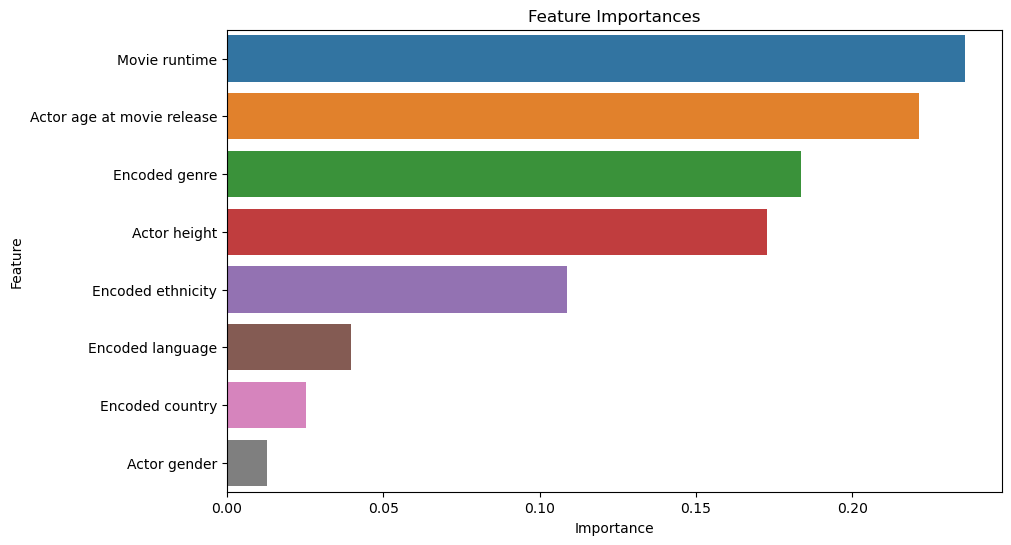

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

It makes sense that gender does not matter much since both men and women win as many Oscars.

In [29]:
X.columns

Index(['Actor gender', 'Actor age at movie release', 'Actor height',
       'Movie runtime', 'Encoded language', 'Encoded genre', 'Encoded country',
       'Encoded ethnicity'],
      dtype='object')

In [30]:
def transform_features(input_features):
    """Reverses encoding for prediction"""
    string_indices = [0, 4, 5, 6, 7] # to change if order of variables changes
    
    for index in string_indices:
        if input_features[index] in gender_mapping:
            input_features[index] = gender_mapping[input_features[index]]
        elif input_features[index] in language_dict:
            input_features[index] = language_dict[input_features[index]]
        elif input_features[index] in genre_dict:
            input_features[index] = genre_dict[input_features[index]]
        elif input_features[index] in country_dict:
            input_features[index] = country_dict[input_features[index]]
      #   elif input_features[index] in ethnicity_dict:
      #      input_features[index] = ethnicity_dict[input_features[index]]

    return input_features

In [31]:
# Prediction of oscars based on an input vector of features

input_features = ['F',54,1.76,110,'English', 'Thriller', 'United States of America', 126]
transformed_features = transform_features(input_features)

predicted_label = model.predict([transformed_features])[0] # we need a mapping of ethnicities to interpret it
outcome = outcome_mapping[predicted_label]

print('This actor/actress {}.'.format(outcome))

This actor/actress gets nothing.


/Users/atoure/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Creating a score index

We want to create a score between 0 and 5 based on the probability of being nominated or winning an Oscar for a given movie and actor. 
For instance, we can assign the score 5 for someone winning and 3 for someone being nominated. Then, we use probabilities to weigh this score and obtain an index between 0 and 5.

In [32]:
proba = model.predict_proba([transformed_features])

/Users/atoure/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [33]:
oscar_score = 5*proba[0][2] + 3*proba[0][1]

In [34]:
print('Given the probabilities {}, the Award score is {}.'.format(proba, round(oscar_score,2)))

Given the probabilities [[0.993 0.007 0.   ]], the Award score is 0.02.


### Limitations of the dataset

The Oscars take place in the US and are usually political. It is less likely for popular foreign actors to win an award outside the best international film category, even if some film industries are very big outside of Hollywood, such as Bollywood and Nollywood.

We haven't found an exhaustive dataset of awards. We might decide to extend the analysis to more award ceremonies but none is exempt from this national preference: The Australian Film Institute Awards, The BAFTA Film Awards (UK), the Césars Film Awards (France), the Golden Bears (Germany), the Golden Globes (US), the Golden Lions (Venice), the Palme d'Or awards (France), the Sundance Film Festival awards (independent movies), Filmfare (Hindi), etc.

We do not aim at doing an exhaustive analysis, but it is important here to understand that we have a Western bias and we might need to use other indicators to better understand success of actors outside of Hollywood. 

Using our score indices complementarily is key to go past potential biases.

In [35]:
# What are movie nationalities of actors that won an Oscar?
oscar_winers = characters_oscars[characters_oscars['winner'] == True].merge(movies, on='Freebase movie ID', how='left') 

# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in oscar_winers["Movie countries"] for country in countries_dict.values())

filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

sorted_countries_counts # Indian movies are not represented at all despite their big industry

{'United States of America': 12598,
 'United Kingdom': 2393,
 'France': 667,
 'Germany': 530,
 'Italy': 507}

Another issue is that we do not have mapping of ethnicity so we even though we know this feature matters, we cannot really explain how. Additionally, it is largely missing, so it might be better not to include it.

In [36]:
result = characters_movie_oscars.groupby('Actor ethnicity')['Actor name'].agg(['first', 'count']).sort_values(by='count', ascending=False).nlargest(5, 'count')

for ethnicity, values in result.iterrows():
    print(f"For '{ethnicity}':")
    print(f"  - First actor: {values['first']}")
    print(f"  - Total count: {values['count']}")
    print("----")
    
# Indian, white, black? Seems more precise than this

For '/m/0dryh9k':
  - First actor: Mohanlal
  - Total count: 16555
----
For '/m/041rx':
  - First actor: Seth Green
  - Total count: 12244
----
For '/m/0x67':
  - First actor: Ice Cube
  - Total count: 10947
----
For '/m/02w7gg':
  - First actor: Pete Postlethwaite
  - Total count: 7599
----
For '/m/033tf_':
  - First actor: Matt Stone
  - Total count: 5659
----


### Next steps: 
- Comment on feature importance
- What values have a positive influence on outcome (gender matters because women win relatively more?)
- Prompt to give bounds and options and to select the relevant features
- Use more datasets or motivate this one?

## 2.2 Cumulated revenues of movies

### Preparing the dataset

Here, we are looking at an aggregate outcome throughout one's career. Contrary to the previous analysis, we want to associate here an amount to characteristics that are fixed over an actor's career. Someone's age on the movie release date no longer matters, but their career start date might. Gender and height are still relevant. For movie characteristics, we can aggregate them over the career, selecting the largest occurence for instance.

Hence, we isolate the following variables that might explain cumulated movie revenues:
- Actor's age at the beginning of their career
- Actor's gender
- Mean age during the career
- Actor's ethnicity
- Actor's height
- Most frequent movie language
- Most frequent country of the movie
- Variety of movie genres
- (to add: variety of roles)

**Merge actors with their movies within the CMU Movie Corpus**

In [37]:
actors_movies = characters.merge(movies, on='Freebase movie ID', how='left') 

In [38]:
actors_movies.columns

Index(['Wikipedia movie ID_x', 'Freebase movie ID', 'Movie release date_x',
       'Character name', 'Actor date of birth', 'Actor gender', 'Actor height',
       'Actor ethnicity', 'Actor name', 'Actor age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID', 'Wikipedia movie ID_y', 'Movie name',
       'Movie release date_y', 'Movie box office revenue', 'Movie runtime',
       'Movie languages', 'Movie countries', 'Movie genres'],
      dtype='object')

**Aggregate variables of interest to have values valable for the entire career span**

In [39]:
# Aggregation function to get the length of list of unique values in dictionaries
def count_unique(series):
    if all(not my_dict for my_dict in series):
        return None
    else:
        return len(set(val for sublist in series for val in sublist))
    #return len(unique_countries) if unique_countries else None  # Return None for empty sets

# Aggregation function to get the most frequent value of a column
def most_frequent_occ(series): 
    if not series.empty and not series.isna().all():
        return series.mode().iloc[0]  
    else:
        return None
    
def most_frequent_in_dictionary(series):
    if all(not my_dict for my_dict in series):
        return None
       
    else:
        # Flatten the list of dictionaries
        flattened_values = [item for sublist in series for item in sublist.values()]

        # Create a pandas Series from the flattened values
        flattened_series = pd.Series(flattened_values)

        # Calculate the mode of the flattened Series
        mode_value = flattened_series.mode().iloc[0]
        return mode_value

In [40]:
actors_revenues = actors_movies.groupby('Actor name')

# Aggregating the desired statistics
actor_statistics = actors_revenues.agg({
    'Movie box office revenue': lambda x: x.fillna(0).sum(),
    'Actor gender': most_frequent_occ,
    'Actor age at movie release': 'mean',
    'Actor ethnicity': most_frequent_occ,
    'Actor height': most_frequent_occ,
    'Movie languages': most_frequent_in_dictionary,
    'Movie countries': most_frequent_in_dictionary,
    'Movie genres': most_frequent_in_dictionary,
    'Movie name': 'nunique'
}).reset_index()

In [41]:
# More statistics
age_begin_career = actors_revenues['Actor age at movie release'].min()
unique_countries = actors_revenues['Movie countries'].apply(count_unique) # doesnt work
unique_genres = actors_revenues['Movie genres'].apply(count_unique)
unique_languages = actors_revenues['Movie languages'].apply(count_unique)

# We need precise mapping because they have other columns in common with different values, resulting in NaN
actor_statistics['age_begin_career'] = actor_statistics['Actor name'].map(age_begin_career)
actor_statistics['unique_countries'] = actor_statistics['Actor name'].map(unique_countries)
actor_statistics['unique_genres'] = actor_statistics['Actor name'].map(unique_genres)
actor_statistics['unique_languages'] = actor_statistics['Actor name'].map(unique_languages)

In [42]:
# Renaming the columns for clarity
actor_statistics.columns = ['actor_name','total_revenues','gender','mean_age','ethnicity','height','most_freq_language','most_freq_country','most_freq_genre','unique_movies','age_begin_career','unique_countries','unique_genres','unique_languages'] 
                            
# Displaying the resulting DataFrame
display(actor_statistics)

,actor_name,total_revenues,gender,mean_age,ethnicity,height,most_freq_language,most_freq_country,most_freq_genre,unique_movies,age_begin_career,unique_countries,unique_genres,unique_languages
0,Cesarine Prinz\t,0.0,F,NaN,None,NaN,None,Netherlands,Comedy,2,NaN,1.0,2.0,NaN
1,Daniel Newman,0.0,M,22.000000,None,NaN,English Language,Canada,Drama,1,22.0,3.0,2.0,1.0
2,'Big Bill' Giddinger,0.0,M,NaN,None,NaN,English Language,United States of America,History,1,NaN,1.0,5.0,1.0
3,'Big' Lee,0.0,M,NaN,None,NaN,English Language,United States of America,Crime Fiction,1,NaN,1.0,3.0,1.0
4,'Chicken' Holleman,0.0,None,NaN,None,NaN,English Language,United States of America,Crime Fiction,1,NaN,1.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,0.0,M,22.000000,None,1.85,Japanese Language,Japan,Drama,1,22.0,1.0,4.0,1.0
134074,雪乃五月,0.0,F,30.500000,None,NaN,Japanese Language,Japan,Action,2,30.0,1.0,6.0,1.0
134075,高山久子,0.0,F,35.333333,None,NaN,Japanese Language,Japan,Animation,3,24.0,1.0,12.0,1.0
134076,高橋美紀,0.0,F,24.000000,None,NaN,Japanese Language,Japan,Animation,1,24.0,1.0,2.0,1.0


In [43]:
actor_statistics.columns

Index(['actor_name', 'total_revenues', 'gender', 'mean_age', 'ethnicity',
       'height', 'most_freq_language', 'most_freq_country', 'most_freq_genre',
       'unique_movies', 'age_begin_career', 'unique_countries',
       'unique_genres', 'unique_languages'],
      dtype='object')

In [44]:
# There are a lot of missing values
print(actor_statistics['ethnicity'].notna().sum())
print(len(actor_statistics[actor_statistics['total_revenues']!=0]))

8148
37376


For the outcome, we do not consider different living standards across countries. We already have revenues in USD. However, we want to normalize the revenues per year to account for economic boost and booms that might explain some yearly variation in revenues. Hence we compare the revenues of a movie with respect to the revenues of the median or more profitable movie of the year. 

### Predicting cumulated revenues

**Prepare for the regression**

In [45]:
# Keep only one observation per actor that contains all information
df = actor_statistics.drop_duplicates(subset='actor_name', keep='first') 

# Drop missing values
df = df[['total_revenues','gender', 'most_freq_language','most_freq_country','most_freq_genre','unique_movies','unique_countries','unique_genres','unique_languages']]
print(df.shape) # variables about age are not well filled, as well as height and ethnicity. The remaining missing values are explained by gender
df = df.dropna()
print(df.shape)

(134078, 9)
(92761, 9)


In [46]:
# Use log for the outcome to avoid negative values and consider 0 values as Na
df = df[df['total_revenues'] != 0]
df['log_revenues'] = np.log(df['total_revenues'])

In [47]:
df.dtypes

total_revenues        float64
gender                 object
most_freq_language     object
most_freq_country      object
most_freq_genre        object
unique_movies           int64
unique_countries      float64
unique_genres         float64
unique_languages      float64
log_revenues          float64
dtype: object

In [48]:
# Defining the independent variables and creating dummies
categorical_vars = ['gender']
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
independent_vars = df.drop(['log_revenues','total_revenues','most_freq_language','most_freq_country','most_freq_genre'], axis=1)

In [49]:
# Iterate through columns to change bool into int, it does not work otherwise
for column in independent_vars.columns:
    # Check data type of the column
    current_dtype = independent_vars[column].dtype
    # If the data type is 'boolean', attempt to convert to numeric
    if current_dtype == 'bool':
        independent_vars[column] = independent_vars[column].astype(int)

**Linear regression**

In [50]:
# Adding a constant for the intercept term in the regression
independent_vars = sm.add_constant(independent_vars)

# Creating the model
model = sm.OLS(df['log_revenues'], independent_vars)

# Fitting the model
results = model.fit()

# Displaying the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     2234.
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:09:39   Log-Likelihood:                -66681.
No. Observations:               31300   AIC:                         1.334e+05
Df Residuals:                   31294   BIC:                         1.334e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               15.6349      0.024  

The number of different movies, genres, countries, and languages are statistically significant. 

Quite conterintuitively, playing in one more movie in a career reduces revenues. This might be explained by the fact that big actors play only in a few movies whether those with smaller roles have to play in many small movies to sustain themselves. The many movies they play in is still not enough to gain as much money as big movie stars.

Diversification is positive, as playing in different languages and in different genres increases revenues. However, the revenue decreases with playing in different countries, hence focusing on one movie industry might be beneficial. 

Gender has a non significant impact on revenues. 

The R-square is not so high, indicating that these variables are not enough to explain all variations in actors' cumulated revenues.

### Creating a score index

We want to map revenues to a score between 0 and 5. Since we expect them to follow a power-law distribution,we will first apply a log-transformation. This way, we compress the scale and handle extreme values more effectively. This approach is useful to emphasize differences among lower values while still capturing the variability in the higher values.

**Normalizing a score**

In [51]:
max_revenues = actor_statistics['total_revenues'].max() # $13b

In [52]:
def compute_score(predicted_log_revenues):
    score = predicted_log_revenues/np.log(max_revenues)*5
    return np.clip(score, 0, 5) # to ensure that the score stays within the limits

**Use input feature to predict a score**

In [53]:
input_vector = [1,2,60,10,'M']
constant = [1]
input_vector[4] = gender_mapping[input_vector[4]]

transformed_vector = [1] + input_vector
log_revenues = results.predict(transformed_vector)[0]

print('The predicted revenues are ${} over the career.'.format(round(np.exp(log_revenues),2))) 
# a bit out of bounds, only one movie and $8b. not coherent to have one movie and many genres and languages, we should have bounds

The predicted revenues are $8689492269.53 over the career.


In [54]:
score = round(compute_score(log_revenues),2)
print(score)

4.91


### Limitations

Someone can play an unimportant role in many high revenues movies, it doesn't mean they are getting a lot of income from their movie. However, combined with other indicators, it can give us an idea of the success of someone. Note that we do not establish a causal relationship between the presence of an actor in a movie and the money the movie generated.

### Next steps
- Prompt with maximum values and explanations of variables
- How to deal with missing values, including for the outcome

## 3. Expected outcomes

We aim to provide a more nuanced understanding of the driving factors of success and allow our reader to interact with our results.

- Prediction of all types of success based on a feature input. This can be visualized for instance with a spider chart. *(to do together, what information do we need in each part?)*
- Identification of important features for a given success indicator goal. This will highlight the power one has in being successful. *(done in different parts)*
- Computation of success indicators for actors present in the dataset. This can be visualized with a research tool. *(to do together)*